In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
from tqdm import tqdm

In [61]:
# initialize constants (SI units)
c = 2.99792458e8  # speed of light
m_e = 9.10938356e-31
q_e = 1.60217662e-19
e_0 = 8.85418782e-12
# set pure spectral properties
lambda_0 = 800e-9  # central wavelength
tau_0 = 10e-15  # FL pulse duration 1/e2 intensity half-width (same def as beam waist)
# calculate frequency properties
omega_0 = 2*np.pi*c/lambda_0
delta_omega = 2/tau_0
# set initial beam waist
w_0 = 4e-6
# calculate Rayleigh range
z_R = (np.pi*w_0**2)/(lambda_0)
# beam power
P = 100e12
# chirp
GDD_0 = 0  # Group Delay Dispersion fs^2
GDD = GDD_0*(1e-15)**2
# CEP
Psi_0 = 0.6
# intial electron velocity
z_0 = 0.005*z_R
beta_0 = 0

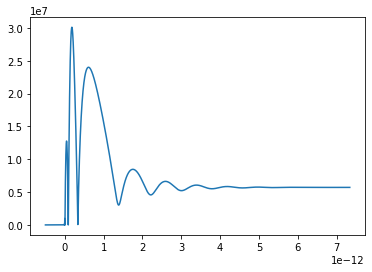

In [62]:
# amplitude factor
Amp = np.sqrt(8*P/(np.pi*e_0*c))
# stretched pulse duration
tau = np.sqrt(tau_0**2 + (2*GDD/tau_0)**2)

t_start = -50*tau_0
t_end = +1e5*tau_0
n = 50
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
time = np.linspace(t_start, t_end, num_t)
dt = time[1]-time[0]

z = np.empty(shape=(len(time)))
beta = np.empty(shape=(len(time)))
deriv1 = np.empty(shape=(len(time)))
deriv2 = np.empty(shape=(len(time)))
KE = np.zeros(shape=(len(time)))

beta[0] = beta_0
z[0] = beta[0]*c*time[0]+z_0

#do 5th order Adams-Bashforth finite difference method
for k in range(0, len(time)-1):
    deriv1[k] = beta[k]*c

    field_temp = np.cos(Psi_0+2*np.arctan(z[k]/z_R)+omega_0*time[k]-omega_0*z[k]/c)/(z_R*(1+(z[k]/z_R)**2))
    env_temp = np.exp(-((time[k]-z[k]/c)/tau)**2)
    temp_phase = np.exp(1j*(2*GDD/(tau_0**4+(2*GDD)**2))*(time[k]-z[k]/c)**2)
    field_total = Amp*(tau_0/tau)*field_temp*env_temp*temp_phase
    deriv2[k] = (-q_e*np.real(field_total)*((1-beta[k]**2)**(3/2))/(m_e*c))

    if k==0:
        z[k+1] = z[k] + dt*deriv1[k]
        beta[k+1] = beta[k] + dt*deriv2[k]
    elif k==1:
        z[k+1] = z[k] + dt*(1.5*deriv1[k]-0.5*deriv1[k-1])
        beta[k+1] = beta[k] + dt*(1.5*deriv2[k]-0.5*deriv2[k-1])
    elif k==2:
        z[k+1] = z[k] + dt*((23/12)*deriv1[k]-(4/3)*deriv1[k-1]+(5/12)*deriv1[k-2])
        beta[k+1] = beta[k] + dt*((23/12)*deriv2[k]-(4/3)*deriv2[k-1]+(5/12)*deriv2[k-2])
    elif k==3:
        z[k+1] = z[k] + dt*((55/24)*deriv1[k]-(59/24)*deriv1[k-1]+(37/24)*deriv1[k-2]-(3/8)*deriv1[k-3])
        beta[k+1] = beta[k] + dt*((55/24)*deriv2[k]-(59/24)*deriv2[k-1]+(37/24)*deriv2[k-2]-(3/8)*deriv2[k-3])
    else:
        z[k+1] = z[k] + dt*((1901/720)*deriv1[k]-(1387/360)*deriv1[k-1]+(109/30)*deriv1[k-2]-(637/360)*deriv1[k-3]+(251/720)*deriv1[k-4])
        beta[k+1] = beta[k] + dt*((1901/720)*deriv2[k]-(1387/360)*deriv2[k-1]+(109/30)*deriv2[k-2]-(637/360)*deriv2[k-3]+(251/720)*deriv2[k-4])

    KE[k+1] = ((1/np.sqrt(1-beta[k+1]**2))-1)*m_e*c**2/q_e
    
    if (time[k] > 100*tau_0 and np.abs(np.mean(np.diff(KE[k-100:k+1])/(KE[k+1]*dt))) < 1e5):
        k_stop = k+1
        break

plt.plot(time[:k_stop], KE[:k_stop])